# Multi-touch Multi-channel Attribution Model Using LSTM with Attention

This is an attribution model that uses LSTM with attention to assign weights to touchpoints. 

| Description | D001 (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
|--|:--|
| Dataset | Criteo (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datsets.md)) |
| Papers | Li2018, Ren2018 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | Download the dataset to 'data' folder |
| Libs | Keras, Scikit-learn, Pandas, Numpy |

### Data description
This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not. Data has been sub-sampled and anonymized so as not to disclose proprietary elements.

Here is a detailed description of the fields (they are tab-separated in the file):

* timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
* uid: a unique user identifier
* campaign: a unique identifier for the campaign
* conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
* conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed
* conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
* attribution: 1 if the conversion was attributed to Criteo, 0 otherwise
* click: 1 if the impression was clicked, 0 otherwise
* click_pos: the position of the click before a conversion (0 for first-click)
* click_nb: number of clicks. More than 1 if there was several clicks before a conversion
* cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
* cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
* time_since_last_click: the time since the last click (in s) for the given impression
* cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

### Key figures
* 2.4Gb uncompressed
* 16.5M impressions
* 45K conversions
* 700 campaigns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = 'criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 50

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

50257
[25304, 24953]


In [3]:
df6.count()

timestamp                     50257
uid                           50257
campaign                      50257
conversion                    50257
conversion_timestamp          50257
conversion_id                 50257
attribution                   50257
click                         50257
click_pos                     50257
click_nb                      50257
cost                          50257
cpo                           50257
time_since_last_click         50257
cat1                          50257
cat2                          50257
cat3                          50257
cat4                          50257
cat5                          50257
cat6                          50257
cat7                          50257
cat8                          50257
cat9                          50257
jid                           50257
timestamp_norm                50257
time_since_last_click_norm    50257
cats                          50257
campaigns                     50257
dtype: int64

In [408]:
# Data exploration
def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df4)

plt.plot(range(len(hist_all)), hist_all, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

NameError: name 'hist_all' is not defined

## Last Touch Attribution

In [4]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

In [5]:
lta

array([0.32575024, 0.18116856, 0.03393214, 0.11188811, 0.06576844,
       0.10510779, 0.11566707, 0.1529052 , 0.1037234 , 0.12603461,
       0.06140351, 0.08656716, 0.13213703, 0.34042553, 0.13389121,
       0.05108055, 0.17412935, 0.05913043, 0.08436725, 0.27192982,
       0.15240642, 0.17607223, 0.32908459, 0.15584416, 0.34210526,
       0.14      , 0.3       , 0.11564626, 0.05582524, 0.30994152,
       0.08108108, 0.25688073, 0.04411765, 0.11328125, 0.19158879,
       0.1978022 , 0.05084746, 0.0625    , 0.20652174, 0.20967742,
       0.23214286, 0.14285714, 0.33333333, 0.29761905, 0.28813559,
       0.05263158, 0.14      , 0.03448276, 0.03669725, 0.        ])

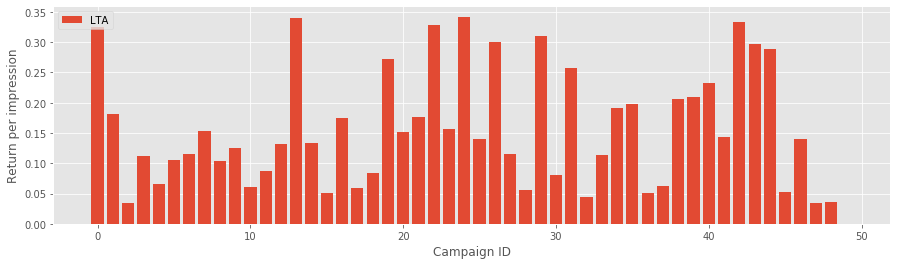

In [6]:
# Visualization of the attribution scores

campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [7]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

In [8]:
fta

array([0.32575024, 0.18116856, 0.03393214, 0.11188811, 0.06576844,
       0.10510779, 0.11566707, 0.1529052 , 0.1037234 , 0.12603461,
       0.06140351, 0.08656716, 0.13213703, 0.34042553, 0.13389121,
       0.05108055, 0.17412935, 0.05913043, 0.08436725, 0.27192982,
       0.15240642, 0.17607223, 0.32908459, 0.15584416, 0.34210526,
       0.14      , 0.3       , 0.11564626, 0.05582524, 0.30994152,
       0.08108108, 0.25688073, 0.04411765, 0.11328125, 0.19158879,
       0.1978022 , 0.05084746, 0.0625    , 0.20652174, 0.20967742,
       0.23214286, 0.14285714, 0.33333333, 0.29761905, 0.28813559,
       0.05263158, 0.14      , 0.03448276, 0.03669725, 0.        ])

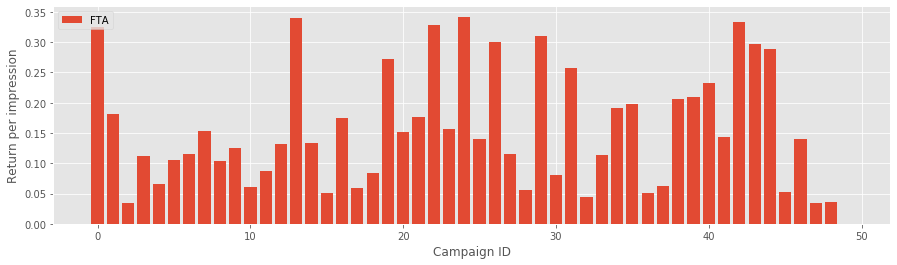

In [9]:
# Visualization of the attribution scores

campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [10]:
def linear_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
#    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
linear = linear_touch_attribution(df6)

In [11]:
linear

array([0.81171346, 0.67087011, 0.14770459, 0.5967366 , 0.24320621,
       0.40665534, 0.38596491, 0.34862385, 0.37765957, 0.58427389,
       0.19298246, 0.26268657, 0.49265905, 0.8443769 , 0.46861925,
       0.22691552, 0.61940299, 0.19130435, 0.32009926, 0.81578947,
       0.38502674, 0.60722348, 0.99652375, 0.7012987 , 0.93421053,
       0.49636364, 0.715     , 0.45918367, 0.1868932 , 0.75438596,
       0.17567568, 0.74311927, 0.09558824, 0.34375   , 0.57009346,
       0.59340659, 0.15254237, 0.16666667, 0.5923913 , 0.51612903,
       0.80357143, 0.72727273, 0.98888889, 0.77380952, 0.91525424,
       0.10526316, 0.36      , 0.06896552, 0.10091743, 0.        ])

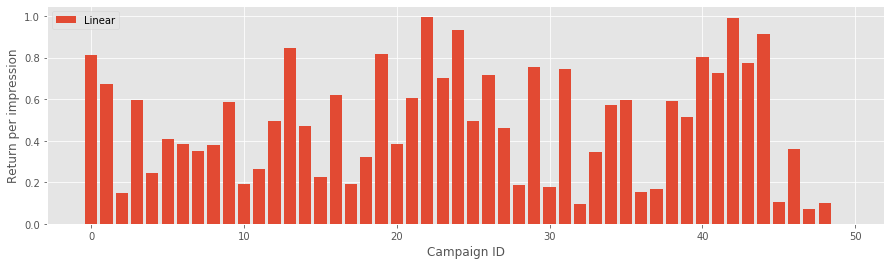

In [12]:
# Visualization of the attribution scores

campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(linear[campaign_idx])), linear[campaign_idx], label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [13]:
def U_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)

    df_converted = df[df['conversion'] == 1]
    temp_jid=0
    campaign_conversions_nrml=0
    campaign_conversions_first=0
    campaign_conversions_last=0
    campaign_conversions_intermediate=0
    for jid in df_converted.jid.unique():
        if jid != temp_jid:
            temp_jid = jid
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() == df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_nrml = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']

                campaign_conversions_nrml = count_by_campaign(df_converted[idx_nrml])
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() != df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_min = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                idx_max = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']

                campaign_conversions_first = count_by_campaign(df_converted[idx_min])
                campaign_conversions_last = count_by_campaign(df_converted[idx_max])
                campaign_conversions_intermediate = (campaign_impressions - (campaign_conversions_first + campaign_conversions_last ))  
    return (((campaign_conversions_nrml + campaign_conversions_first + campaign_conversions_last ) * .7) + (campaign_conversions_intermediate * .3)) / campaign_impressions
    
uta = U_touch_attribution(df6)

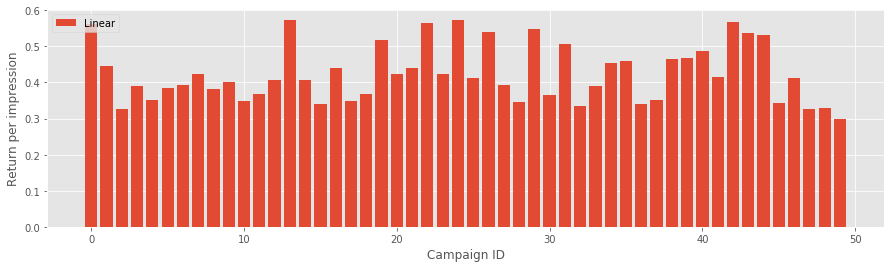

In [14]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uta[campaign_idx])), uta[campaign_idx], label='U-Shaped' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Time Decay

In [49]:
def timrdecay_attribution(df):
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    campaign_impressions = count_by_campaign(df)
    df_converted = df[df['conversion'] == 1]
    temp_jid=0
    campaign_conversions_nrml=0
    campaign_conversions_first=0
    campaign_conversions_last=0
    campaign_conversions_intermediate=0
    for jid in df_converted.jid.unique():
        if jid != temp_jid:
            temp_jid = jid
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() == df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_nrml = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                campaign_conversions_nrml = count_by_campaign(df_converted[idx_nrml])
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() != df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_min = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                idx_max = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
                campaign_conversions_first = count_by_campaign(df_converted[idx_min])
                campaign_conversions_last = count_by_campaign(df_converted[idx_max])
                campaign_conversions_intermediate = (campaign_impressions - (campaign_conversions_first + campaign_conversions_last ))
    return (campaign_conversions_nrml + (campaign_conversions_first * 0.1) + (campaign_conversions_last  * 0.6) + (campaign_conversions_intermediate * 0.3)) / campaign_impressions
tdta = timrdecay_attribution(df6)

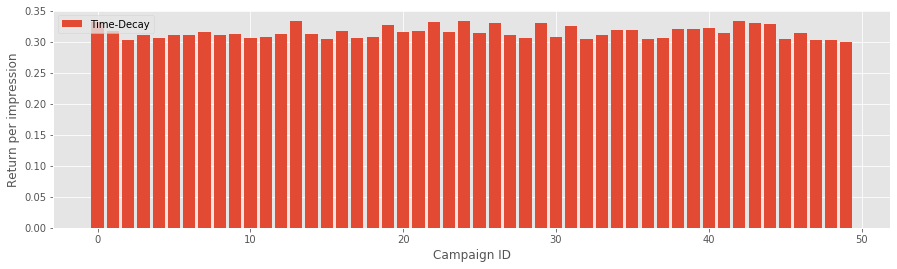

In [50]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(tdta[campaign_idx])), tdta[campaign_idx], label='Time-Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [285]:
#dummy = df6[df6['uid'] == 6881943]

# U Shaped

In [15]:
dummy = df6
dummy_mod=dummy[dummy['conversion']==1]
dummy_mod.sort_values(by=['campaign','timestamp'], inplace=True)
temp_jid = 0 
dummy_array=[]
campaign_array=[]
timestamp_array=[]
ctr=0
for campaign in dummy_mod.campaign.unique():
             ctr = ctr + 1
             for jid in  dummy_mod[dummy_mod['campaign']==campaign].jid.unique():
                if jid != temp_jid:
                    count = 1
                    temp_jid = jid
                    for idx,timestamp in enumerate (dummy_mod[dummy_mod['jid']==jid]['timestamp']):
                        timestamp_array.append(idx+1)
                        campaign_array.append(campaign)
                        if timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(100)
                        elif timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].min():
                            dummy_array.append(100)
                        elif timestamp < dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(50)
                else:
                     count = count + 1

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Campaign No: 1 442617
Campaign No: 2 604249
Campaign No: 3 2077112
Campaign No: 4 2342814
Campaign No: 5 2407403
Campaign No: 6 2576437
Campaign No: 7 3466867
Campaign No: 8 3788051
Campaign No: 9 4800911
Campaign No: 10 5700346
Campaign No: 11 5892331
Campaign No: 12 6341185
Campaign No: 13 7144711
Campaign No: 14 7210407
Campaign No: 15 7697146
Campaign No: 16 8403854
Campaign No: 17 9097334
Campaign No: 18 9100689
Campaign No: 19 9100690
Campaign No: 20 10321103
Campaign No: 21 10686810
Campaign No: 22 12474087
Campaign No: 23 12843319
Campaign No: 24 12845408
Campaign No: 25 13300124
Campaign No: 26 14235907
Campaign No: 27 15500296
Campaign No: 28 15823034
Campaign No: 29 17314989
Campaign No: 30 17321082
Campaign No: 31 17491634
Campaign No: 32 17710659
Campaign No: 33 20916101
Campaign No: 34 21005924
Campaign No: 35 23254639
Campaign No: 36 24045154
Campaign No: 37 25866075
Campaign No: 38 25866076
Campaign No: 39 26729616
Campaign No: 40 26998439
Campaign No: 41 27321366
Campa

In [18]:
leaderboard = pd.DataFrame({'Timestamp':timestamp_array,'Campaign':campaign_array,'Wightage':dummy_array

,Timestamp,Campaign,Wightage
0,1,442617,100
1,2,442617,100
2,1,442617,100
3,2,442617,50
4,3,442617,50
...,...,...,...
24948,1,32398755,100
24949,2,32398755,50
24950,3,32398755,100
24951,1,32398755,100


In [20]:
leaderboard

,Timestamp,Campaign,Wightage
0,1,442617,100
1,2,442617,100
2,1,442617,100
3,2,442617,50
4,3,442617,50
...,...,...,...
24948,1,32398755,100
24949,2,32398755,50
24950,3,32398755,100
24951,1,32398755,100


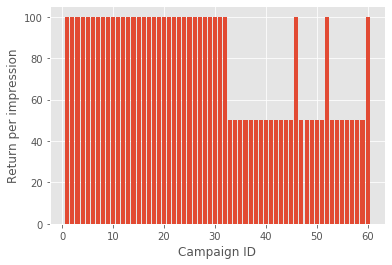

In [17]:
plt.bar(leaderboard['Timestamp'], leaderboard['Wightage'] )
plt.xlabel('Time Distribution')
plt.ylabel('Return per impression')
plt.show()

# FTA

In [21]:
dummy = df6
dummy_mod=dummy[dummy['conversion']==1]
dummy_mod.sort_values(by=['campaign','timestamp'], inplace=True)
temp_jid = 0 
dummy_array=[]
campaign_array=[]
timestamp_array=[]
ctr=0
for campaign in dummy_mod.campaign.unique():
             ctr = ctr + 1
             for jid in  dummy_mod[dummy_mod['campaign']==campaign].jid.unique():
                if jid != temp_jid:
                    count = 1
                    temp_jid = jid
                    for idx,timestamp in enumerate (dummy_mod[dummy_mod['jid']==jid]['timestamp']):
                        timestamp_array.append(idx+1)
                        campaign_array.append(campaign)
                        if timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(0)
                        elif timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].min():
                            dummy_array.append(100)
                        elif timestamp < dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(0)
                else:
                     count = count + 1

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
leaderboard_fta = pd.DataFrame({'Timestamp':timestamp_array,'Campaign':campaign_array,'Wightage':dummy_array})
leaderboard_fta

,Timestamp,Campaign,Wightage
0,1,442617,100
1,2,442617,0
2,1,442617,100
3,2,442617,0
4,3,442617,0
...,...,...,...
24948,1,32398755,100
24949,2,32398755,0
24950,3,32398755,0
24951,1,32398755,100


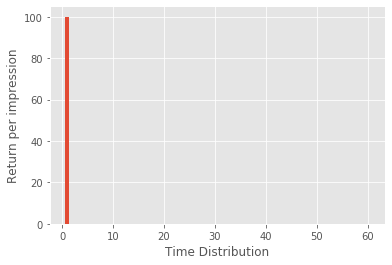

In [46]:
plt.bar(leaderboard_fta['Timestamp'], leaderboard_fta['Wightage'] )
plt.xlabel('Time Distribution')
plt.ylabel('Return per impression')
plt.show()

# Linear

In [25]:
dummy = df6
dummy_mod=dummy[dummy['conversion']==1]
dummy_mod.sort_values(by=['campaign','timestamp'], inplace=True)
temp_jid = 0 
dummy_array=[]
campaign_array=[]
timestamp_array=[]
ctr=0
for campaign in dummy_mod.campaign.unique():
             ctr = ctr + 1
             for jid in  dummy_mod[dummy_mod['campaign']==campaign].jid.unique():
                if jid != temp_jid:
                    count = 1
                    temp_jid = jid
                    for idx,timestamp in enumerate (dummy_mod[dummy_mod['jid']==jid]['timestamp']):
                        timestamp_array.append(idx+1)
                        campaign_array.append(campaign)
                        if timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(100)
                        elif timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].min():
                            dummy_array.append(100)
                        elif timestamp < dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(100)
                else:
                     count = count + 1

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
leaderboard_linear = pd.DataFrame({'Timestamp':timestamp_array,'Campaign':campaign_array,'Wightage':dummy_array})
leaderboard_linear

,Timestamp,Campaign,Wightage
0,1,442617,100
1,2,442617,100
2,1,442617,100
3,2,442617,100
4,3,442617,100
...,...,...,...
24948,1,32398755,100
24949,2,32398755,100
24950,3,32398755,100
24951,1,32398755,100


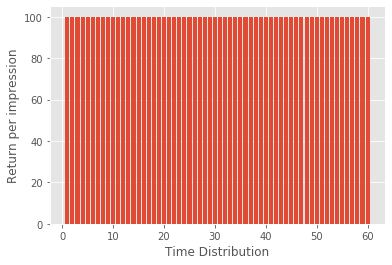

In [45]:
plt.bar(leaderboard_linear['Timestamp'], leaderboard_linear['Wightage'] )
plt.xlabel('Time Distribution')
plt.ylabel('Return per impression')
plt.show()

# LTA

In [27]:
dummy = df6
dummy_mod=dummy[dummy['conversion']==1]
dummy_mod.sort_values(by=['campaign','timestamp'], inplace=True)
temp_jid = 0 
dummy_array=[]
campaign_array=[]
timestamp_array=[]
ctr=0
for campaign in dummy_mod.campaign.unique():
             ctr = ctr + 1
             for jid in  dummy_mod[dummy_mod['campaign']==campaign].jid.unique():
                if jid != temp_jid:
                    count = 1
                    temp_jid = jid
                    for idx,timestamp in enumerate (dummy_mod[dummy_mod['jid']==jid]['timestamp']):
                        timestamp_array.append(idx+1)
                        campaign_array.append(campaign)
                        if timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(100)
                        elif timestamp == dummy_mod[dummy_mod['jid']==jid]['timestamp'].min():
                            dummy_array.append(0)
                        elif timestamp < dummy_mod[dummy_mod['jid']==jid]['timestamp'].max():
                            dummy_array.append(0)
                else:
                     count = count + 1

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
leaderboard_lta = pd.DataFrame({'Timestamp':timestamp_array,'Campaign':campaign_array,'Wightage':dummy_array})
leaderboard_lta

,Timestamp,Campaign,Wightage
0,1,442617,0
1,2,442617,100
2,1,442617,0
3,2,442617,0
4,3,442617,0
...,...,...,...
24948,1,32398755,0
24949,2,32398755,0
24950,3,32398755,100
24951,1,32398755,0


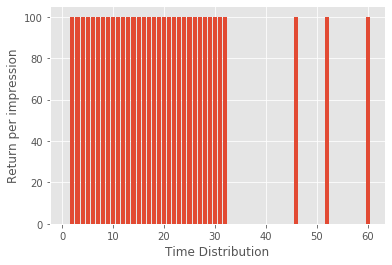

In [44]:
plt.bar(leaderboard_lta['Timestamp'], leaderboard_lta['Wightage'] )
plt.xlabel('Time Distribution')
plt.ylabel('Return per impression')
plt.show()

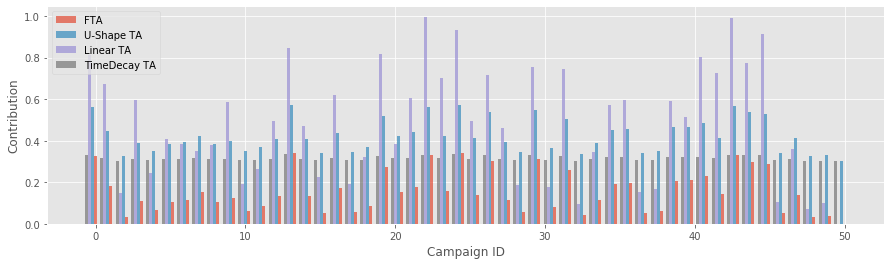

In [61]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
#ratio = max(fta[idx]) / max(uta[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), fta[campaign_idx], width=0.2, alpha=0.7, label='FTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.2, uta[campaign_idx], width=0.2, alpha=0.7, label='U-Shape TA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.4, linear[campaign_idx], width=0.2, alpha=0.7, label='Linear TA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.6, tdta[campaign_idx], width=0.2, alpha=0.7, label='TimeDecay TA' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

## Logistic Regression

In [29]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [30]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(11482, 286)


In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [32]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8232477144101001


C:\Users\kumar\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [33]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 7348 samples, validate on 1837 samples
Epoch 1/10
7348/7348 [==============================] - 0s 26us/step - loss: 0.6668 - accuracy: 0.6000 - val_loss: 0.6241 - val_accuracy: 0.6815
Epoch 2/10
7348/7348 [==============================] - 0s 11us/step - loss: 0.6019 - accuracy: 0.7011 - val_loss: 0.5795 - val_accuracy: 0.7180
Epoch 3/10
7348/7348 [==============================] - 0s 10us/step - loss: 0.5655 - accuracy: 0.7467 - val_loss: 0.5494 - val_accuracy: 0.7714
Epoch 4/10
7348/7348 [==============================] - 0s 11us/step - loss: 0.5398 - accuracy: 0.7844 - val_loss: 0.5278 - val_accuracy: 0.7942
Epoch 5/10
7348/7348 [==============================] - 0s 12us/step - loss: 0.5206 - accuracy: 0.7953 - val_loss: 0.5114 - val_accuracy: 0.8046
Epoch 6/10
7348/7348 [==============================] - 0s 12us/step - loss: 0.5061 - accuracy: 0.7982 - val_loss: 0.4990 - val_accuracy: 0.8084
Epoch 7/10
7348/7348 [==============================] - 0s 12us/step - loss: 0.495

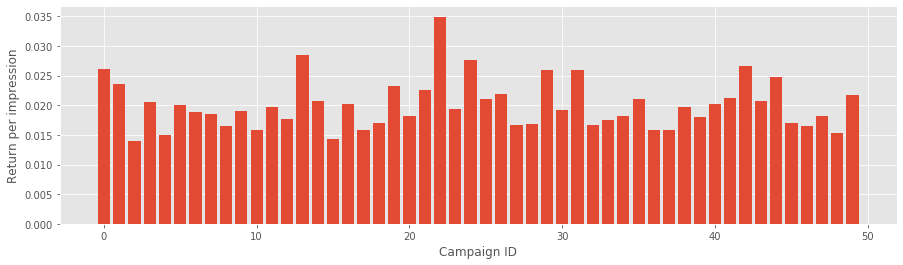

In [34]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

## Basic LSTM

In [35]:
def features_for_lstm(df, max_touchpoints):
    
    df_proj = df[['jid', 'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion']]
    
    x2d = df_proj.values
    
    x3d_list = np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1])
    
    x3d = []
    y = []
    for xi in x3d_list:
        journey_matrix = np.apply_along_axis(np.hstack, 1, xi)
        journey_matrix = journey_matrix[ journey_matrix[:, 5].argsort() ] # sort impressions by timestamp
        n_touchpoints = len(journey_matrix)
        padded_journey = []
        if(n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints), (0, 0)), 'constant', constant_values=(0))
            
        x3d.append(padded_journey[:, 0:-1])
        y.append(np.max(padded_journey[:, -1]))
        
    return np.stack(x3d), y

x, y = features_for_lstm(df6, max_touchpoints = 15)
print(np.shape(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

(11482, 15, 288)


In [36]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM

n_steps, n_features = np.shape(x)[1:3]
    
model = Sequential() 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 7348 samples, validate on 1837 samples
Epoch 1/5
7348/7348 [==============================] - 2s 322us/step - loss: 0.4035 - accuracy: 0.8186 - val_loss: 0.3161 - val_accuracy: 0.8704
Epoch 2/5
7348/7348 [==============================] - 2s 277us/step - loss: 0.3518 - accuracy: 0.8424 - val_loss: 0.3131 - val_accuracy: 0.8639
Epoch 3/5
7348/7348 [==============================] - 2s 295us/step - loss: 0.3426 - accuracy: 0.8453 - val_loss: 0.3105 - val_accuracy: 0.8639
Epoch 4/5
7348/7348 [==============================] - 2s 290us/step - loss: 0.3346 - accuracy: 0.8519 - val_loss: 0.3132 - val_accuracy: 0.8590
Epoch 5/5
7348/7348 [==============================] - 2s 272us/step - loss: 0.3288 - accuracy: 0.8514 - val_loss: 0.3306 - val_accuracy: 0.8481
Test score: 0.324456744522025
Test accuracy: 0.841967761516571


## LSTM with Attention

In [37]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras.constraints import NonNeg
from keras import backend as K
from keras.models import Model

n_steps, n_features = np.shape(x)[1:3]

hidden_units = 64

main_input = Input(shape=(n_steps, n_features))
    
embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

main_output = Dense(1, activation='sigmoid')(weighted_activations)

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 7348 samples, validate on 1837 samples
Epoch 1/5
7348/7348 [==============================] - 2s 277us/step - loss: 0.3363 - accuracy: 0.8488 - val_loss: 0.2812 - val_accuracy: 0.8857
Epoch 2/5
7348/7348 [==============================] - 2s 259us/step - loss: 0.2635 - accuracy: 0.8870 - val_loss: 0.2687 - val_accuracy: 0.8889
Epoch 3/5
7348/7348 [==============================] - 2s 285us/step - loss: 0.2393 - accuracy: 0.8985 - val_loss: 0.2464 - val_accuracy: 0.8906
Epoch 4/5
7348/7348 [==============================] - 2s 285us/step - loss: 0.2272 - accuracy: 0.9015 - val_loss: 0.2429 - val_accuracy: 0.8895
Epoch 5/5
7348/7348 [==============================] - 2s 301us/step - loss: 0.2211 - accuracy: 0.9050 - val_loss: 0.2509 - val_accuracy: 0.8933
Test score: 0.2413541278114618
Test accuracy: 0.9037875533103943


## Analysis of LSTM-A Model

In [38]:
from keras.models import Model
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)

a = attention_model.predict(x_train)

attributions = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)
for i, journey in enumerate(a):
    for step, step_contribution in enumerate(journey):
        if(np.sum(x_train[i][step]) > 0):
            campaign_id = get_campaign_id(x_train[i][step])
            attributions[campaign_id] = attributions[campaign_id] + step_contribution
            campaign_freq[campaign_id] = campaign_freq[campaign_id] + 1

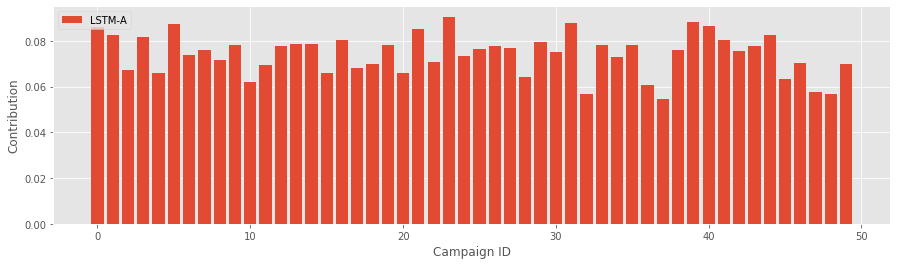

In [39]:
lstm_a = (attributions/campaign_freq)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='LSTM-A' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[idx]) / max(keras_logreg[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, keras_logreg[campaign_idx], width=0.4, alpha=0.7, label='Keras Log Reg' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

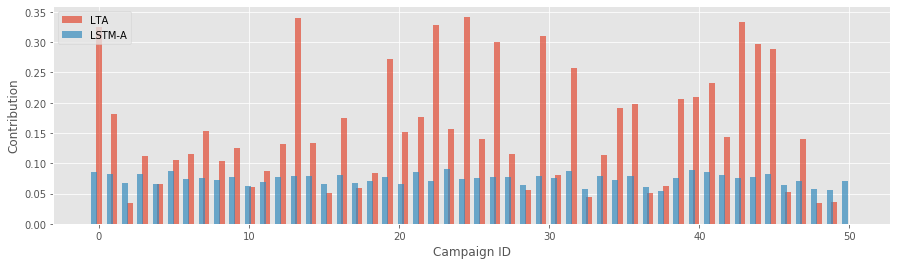

In [41]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[campaign_idx]) / max(lstm_a[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, lstm_a[campaign_idx], width=0.4, alpha=0.7, label='LSTM-A'  )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

## Simulation

In [42]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [63]:
pitches = [0.5, 1.0, 2.0, 3.0]
attributions = [lta, fta, uta, tdta]
reward=[]
att=[]
pitch=[]
for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(pitch, j, reward))

0.5 0 : 713
0.5 1 : 713
0.5 2 : 632
0.5 3 : 605
1.0 0 : 828
1.0 1 : 828
1.0 2 : 651
1.0 3 : 608
2.0 0 : 977
2.0 1 : 977
2.0 2 : 719
2.0 3 : 618
3.0 0 : 1200
3.0 1 : 1200
3.0 2 : 800
3.0 3 : 632
